# Введение в оспользование [antspy](https://github.com/ANTsX/ANTsPy) и MRTDataset

In [1]:
import ants

Скармливаете `ants.image_read()` путь до `.nii.gz` или `.mni`

<IPython.core.display.Javascript object>


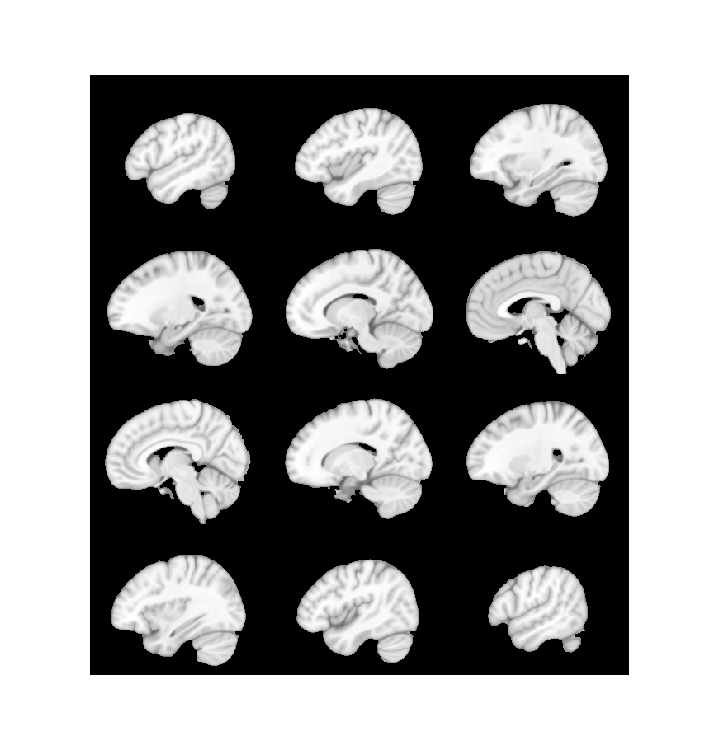

In [37]:
img = ants.image_read(ants.get_ants_data('mni'))
img.plot()

Это все легко перегоняется в numpy массивы

In [39]:
img_array = img.numpy()
img_array.shape, img_array.max()

((182, 218, 182), 8364.0)

Это все дело можно нормировать

In [40]:
ants.iMath_normalize(img).max()

1.0

Также удобно ресайзить

In [48]:
print(img.shape)
img.resample_image((10, 20, 30), 1, 0).shape

(182, 218, 182)


(10, 20, 30)

Также можно поворачивать

In [50]:
ants.reorient_image(img, (1,0))

{'reoimage': ANTsImage (RPI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (182, 218, 182)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (-90.0, 126.0, -72.0)
 	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.],
 'txfn': '/tmp/tmpv3di83hp.mat'}

Ну и гонять массивы назад в мозги

In [52]:
new_img1 = img.new_image_like(img_array)

# doesnt copy any information
new_img2 = ants.from_numpy(img_array)

# verbose way to copy information
new_img3 = ants.from_numpy(img_array, spacing=img.spacing,
                           origin=img.origin, direction=img.direction)

## Теперь перейдем к датасету

In [2]:
%matplotlib notebook
import os, sys
from matplotlib import pyplot

sys.path.append('/root/cAAE')
from model.tools.config import Config, read_conf
from model.generator import generator, net

config = read_conf(f'/root/cAAE/config/{os.environ["CONFIG_NAME"]}.json')

In [28]:
def plot_all_axis(brain):
    n=2/3
    fig, axs = pyplot.subplots(1, 3)
    axs[0].imshow(brain[int(brain.shape[0]*n), :, :])
    axs[0].set_title('Brain axis = 0')
    axs[1].imshow(brain[:, int(brain.shape[1]*n), :])
    axs[1].set_title('Brain axis = 1')
    axs[2].imshow(brain[:, :, int(brain.shape[1]*n)])
    axs[2].set_title('Brain axis = 2')

Давайте посмотрим на датасеты. Сначала на тренировочный (`train_flg = True`)

In [9]:
dataset = generator(config, train_flg=True)

Основа датасета это объект класса `Person`. Датасет веде себя и как словарь и как список

In [10]:
person = dataset.get_person(11) #Или случайный dataset.get_random()
person

85db1133-e94a-4a5e-aa94-5c6220: T2w_restore_brain_114419

Если вызывать `dataset[i]`, то будет вызвано `person.__call__` с `transform`, которая есть в датасете

In [11]:
print(dataset.transform)
brain = dataset[11]
brain.shape

Compose(
    <function iMath_normalize at 0x7f73e766bc80>
    <function generator.<locals>.resize at 0x7f727dd0c0d0>
    <function generator.<locals>.<lambda> at 0x7f727dd0c730>
    ToTensor()
)


torch.Size([260, 64, 64])

Давайте посмотрим на преобразованный тензор. Желательно следить за направлением мозга по каждой из осей, чтобы на трейне и на тесте данные были соноправленны.

<IPython.core.display.Javascript object>


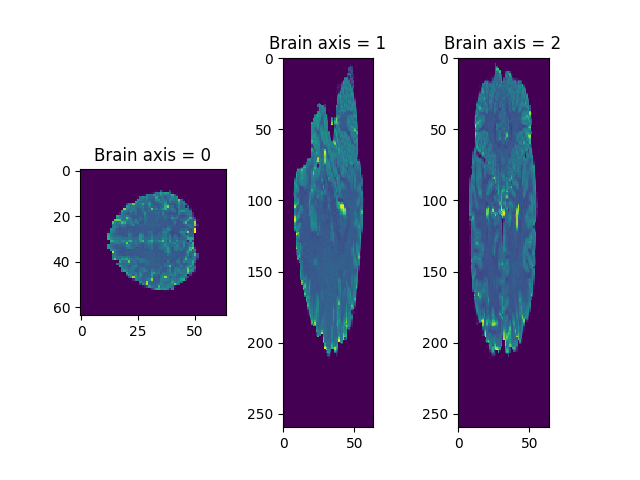

In [29]:
plot_all_axis(brain)

А теперь посмотрим на то, как оно выглядело в оригинале

<IPython.core.display.Javascript object>


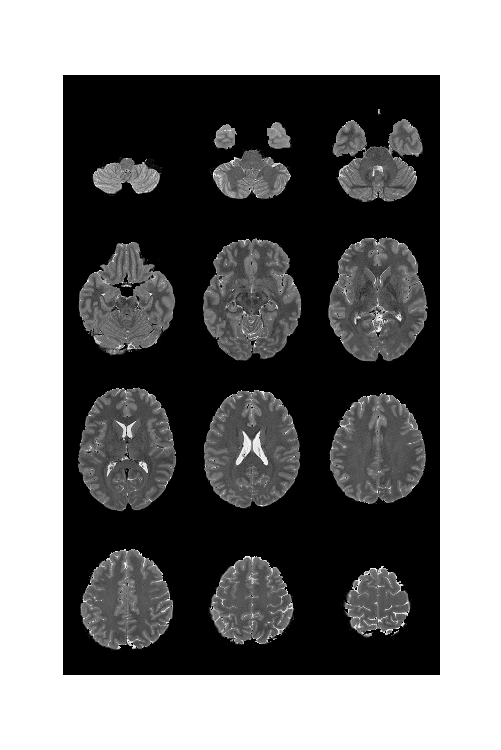

In [13]:
person.plot(axis=2)

Для тестовых данных работает все тоже самое, но появляется еще и возможность посмотреть на опухоли

In [14]:
dataset_test = generator(config, train_flg=False)

In [21]:
person_test = dataset_test.get_person(11)
print(dataset_test.transform) #должен быть такой же, как и трейн
brain_test = dataset_test[11]
brain_test.shape

Compose(
    <function iMath_normalize at 0x7f73e766bc80>
    <function generator.<locals>.resize at 0x7f728a2b3048>
    <function generator.<locals>.<lambda> at 0x7f728a2b32f0>
    ToTensor()
)


torch.Size([155, 64, 64])

Должны смотреть в том же направлении, что и трейн

<IPython.core.display.Javascript object>


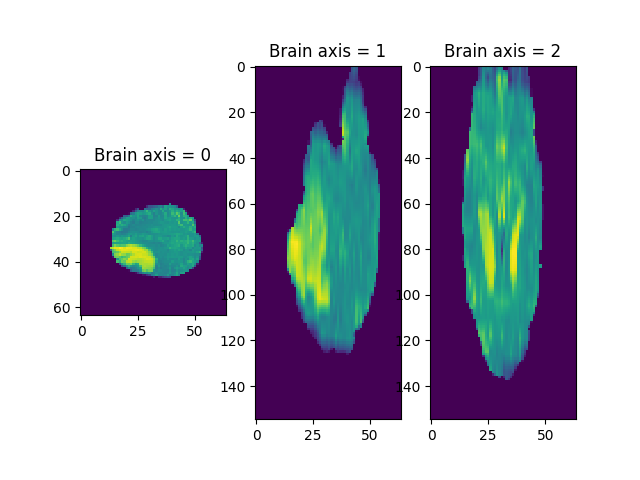

In [30]:
plot_all_axis(brain_test)

Так получается маска, она вам понадобится

<IPython.core.display.Javascript object>


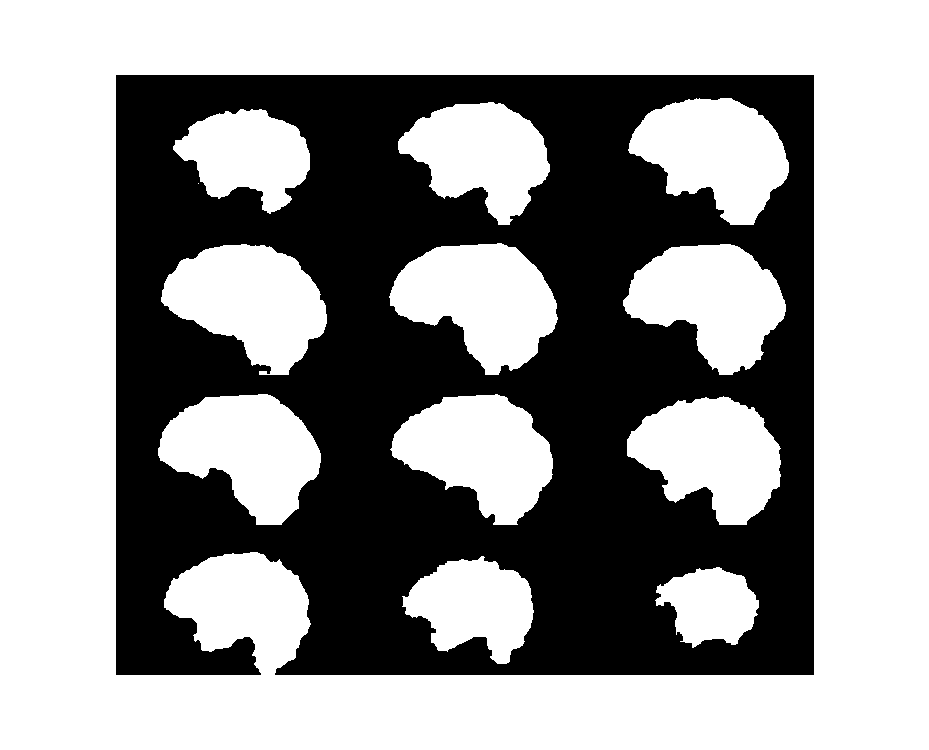

In [22]:
person_test.get_mask().plot()

Для того, чтобы получить опухоль, надо сначала ее подвязать

In [24]:
person_test.set_tumor()
tumor = person_test.get_tumor(dataset_test.transform)

<IPython.core.display.Javascript object>


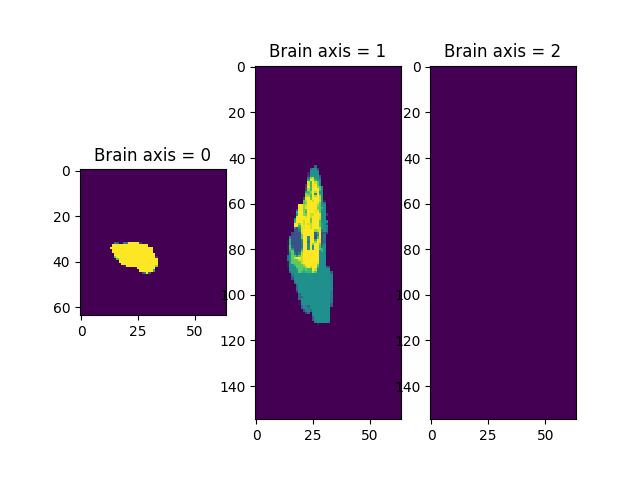

In [31]:
plot_all_axis(tumor)